## Notebook to define the Antarctic Circumpolar Current speed, based on the location of the slope front

In this notebook I will define the ASC speed, according the the location of the Antarctic Slope Front. The methodology will follow the follwoing steps.

## Part 1 - Defining the calculation domain
1st -  Define the northern limit for assessment. This limit will be the 2000m isobath, as it seems to be reasonably north of the ASC (check image below). Any U,V point north of the 2500m isobath will be masked out

<div>
<img src=http://localhost:8889/files/x77_wf4500/ASC_project/Screenshot.png?_xsrf=2%7C8efcce90%7Ccfbed000a96778f130e11d12f7bf853e%7C1682470238?_xsrf=2%7Ce7642a83%7C0a11d886fe09ceefb7d81a25d09d5077%7C1683074692 width="800"/>
</div>



In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt
import os
import xarray as xr
import numpy as np
import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import pylab
import cosima_cookbook as cc
session = cc.database.create_session()
from dask.distributed import Client
client = Client(n_workers=28)
client

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)
logging.getLogger('distributed.utils_perf').setLevel(logging.ERROR)

Importing U,V and the bathymetry, and make any appropriate means or averages

In [2]:
#Getting variables
#variable = 'uvel'
experiment = '01deg_jra55v13_ryf9091'
UVEL = cc.querying.getvar(experiment, 'u' , session, frequency='1 monthly', n=-40)
UVEL = UVEL.isel({'yu_ocean': slice(0, 494)})#.isel({'st_ocean': slice(0, 40)})# First 500 m
VVEL = cc.querying.getvar(experiment, 'v' , session, frequency='1 monthly',n=-40)
VVEL = VVEL.isel({'yu_ocean': slice(0, 494)})#.isel({'st_ocean': slice(0, 40)})
dzt = cc.querying.getvar(experiment, 'dzt' , session, frequency='1 monthly',n=-40)
dzt = dzt.isel({'yt_ocean': slice(0, 494)})#.isel({'st_ocean': slice(0, 40)})
# To minimize computational efforts you can....
      # Set ylim to get only the Southermost Latitudes of the Southern Ocean (Lets say south of 60S)
      # Set a depth limit too.. perhaps 1000m or 500 m
      #When I calculate the mean it has to be a weighted mean against dzt
#Load the bathymetry
hu = cc.querying.getvar(experiment, 'hu', session, n=1).drop(['geolat_c', 'geolon_c']).isel({'yu_ocean': slice(0, 494)})

# Calculating yearly mean of U,V
VVELmean = VVEL.groupby('time.year').mean('time').mean('year')
UVELmean = UVEL.groupby('time.year').mean('time').mean('year')
dztmean = dzt.groupby('time.year').mean('time').mean('year')

#Regridding them
import xgcm
print("xgcm version ", xgcm.__version__)
folder = '/scratch/v45/wf4500/simulations/01deg_jra55_ryf_zmin21m/wf4500/access-om2/archive/ryf/output000/ocean/'
grid = xr.open_mfdataset(folder+'ocean_grid.nc', combine='by_coords').isel({'yu_ocean': slice(0, 494)}).isel({'yt_ocean': slice(0, 494)})

ds = xr.merge([UVELmean,VVELmean,dztmean, grid])
ds.coords['xt_ocean'].attrs.update(axis='X')
ds.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
ds.coords['yt_ocean'].attrs.update(axis='Y')
ds.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)
grid = xgcm.Grid(ds, periodic=['X','Y'])

#Weighted mean Along Z
UVELmeanz = ((grid.interp(UVELmean,['X','Y'])*dztmean).sum('st_ocean'))/dztmean.sum('st_ocean')
VVELmeanz = ((grid.interp(VVELmean,['X','Y'])*dztmean).sum('st_ocean'))/dztmean.sum('st_ocean')



xgcm version  0.8.1


In [21]:
# #Getting the isobath
bath = xr.open_dataset('/home/156/wf4500/access-om2-01/ryf/archive/output000/ocean/ocean_grid.nc')
bath=bath.ht
lat_range = slice(-90, -56)
# select one year and latitude range
bath_mean = bath.sel(yt_ocean = lat_range)

#contour_depth = 800
h = bath_mean.load()

# # Fill in land with zeros:
# h = h.fillna(0)

# #Creating the mask for the Bathymetry
# hmask =  h.where((h >= 800))
# hmask= hmask/hmask

In [4]:
# # Select the contour we want
# fig = plt.figure(figsize = (10, 4))
# count = 1
# x_contour = []
# y_contour = []

# sc = plt.contour(h, levels=[800])
# for collection in sc.collections:
#     for path in collection.get_paths():
#         count += 1
#         if count ==  2:
#             # Write down the lat/lon indices
#             for ii in range(np.size(path.vertices[:,0])):
#                 x_contour.append(int(np.round(path.vertices[ii][0])))
#                 y_contour.append(int(np.round(path.vertices[ii][1])))


Now Creating the actual mask

In [5]:
# # Difference between two neighbouring indices
# diff_x_contour = np.diff(x_contour)
# diff_y_contour = np.diff(y_contour)

# # Get a list with the indices of duplicates
# diff_ind = []
# for ii in range(len(diff_x_contour)):
#     if (diff_x_contour[ii]==0) and (diff_y_contour[ii]==0):
#         diff_ind.append(ii)
        
# # Now remove the indices (start from the end so the indices don't shift)
# for ii in range(len(diff_ind)):
#     index = diff_ind[::-1][ii]
#     del x_contour[index]
#     del y_contour[index]

# h_contour = np.zeros(len(x_contour))

# for ii in range(len(h_contour)):
#     h_contour[ii] = h[y_contour[ii], x_contour[ii]]
    
# xt_ocean = cc.querying.getvar(experiment, 'xt_ocean' , session, frequency='1 monthly', n=-1)
# yt_ocean = cc.querying.getvar(experiment, 'yt_ocean' , session, frequency='1 monthly', n=-1)
# xu_ocean = cc.querying.getvar(experiment, 'xu_ocean' , session, frequency='1 monthly', n=-1)
# yu_ocean = cc.querying.getvar(experiment, 'yu_ocean' , session, frequency='1 monthly', n=-1)

# grid_sel = 't'
# if grid_sel == 'u':
#     x_var = xu_ocean
#     y_var = yu_ocean
# elif grid_sel == 't':
#     x_var = xt_ocean
#     y_var = yt_ocean

# lat_along_contour = np.zeros((len(x_contour)))
# lon_along_contour = np.zeros((len(x_contour)))

# for ii in range(len(h_contour)):
#     lon_along_contour[ii] = x_var[x_contour[ii]]
#     lat_along_contour[ii] = y_var[y_contour[ii]]
    
# lat_along_contour = np.append(lat_along_contour, lat_along_contour[0])
# lon_along_contour = np.append(lon_along_contour, lon_along_contour[0])
# # Number of grid points on the contour
# num_points = len(lat_along_contour)
# contour_mask_numbered = np.zeros_like(lon_along_contour)

# for ii in range(num_points-1):
#     lat1 = lat_along_contour[ii]
#     lat2 = lat_along_contour[ii+1]
#     lon1 = lon_along_contour[ii]
#     lon2 = lon_along_contour[ii+1]
#     contour_mask_numbered[ii] = ii
# contour_mask = h*0

# for ii in range(num_points-1):
#     contour_mask[y_contour[ii], x_contour[ii]] = contour_mask_numbered[ii]+1
    
# mask_value = -800
# contour_mask_numbered = contour_mask

# # fill in points to south of contour:
# contour_masked_above = np.copy(contour_mask_numbered)
# contour_masked_above[-1, 0] = mask_value

# # from top left:
# for ii in range(len(contour_mask.xt_ocean)-1):
#     for jj in range(len(contour_mask.yt_ocean))[::-1][:-1]:
#         if contour_masked_above[jj, ii] == mask_value:
#             if contour_masked_above[jj-1, ii] == 0:
#                 contour_masked_above[jj-1, ii] = mask_value
#             if contour_masked_above[jj, ii+1] == 0:
#                 contour_masked_above[jj, ii+1] = mask_value

# #from top right:
# for ii in range(len(contour_mask.xt_ocean))[::-1][:-1]:
#     for jj in range(len(contour_mask.yt_ocean))[::-1][:-1]:
#         if contour_masked_above[jj, ii] == mask_value:
#             if contour_masked_above[jj-1, ii] == 0:
#                 contour_masked_above[jj-1, ii] = mask_value
#             if contour_masked_above[jj, ii-1] == 0:
#                 contour_masked_above[jj, ii-1] = mask_value

# # from bottom right:
# for ii in range(len(contour_mask.xt_ocean))[::-1][:-1]:
#     for jj in range(len(contour_mask.yt_ocean)-1):
#         if contour_masked_above[jj, ii] == mask_value:
#             if contour_masked_above[jj+1, ii] == 0:
#                 contour_masked_above[jj+1, ii] = mask_value
#             if contour_masked_above[jj, ii-1] == 0:
#                 contour_masked_above[jj, ii-1] = mask_value

# #from bottom left:
# for ii in range(len(contour_mask.xt_ocean)-1):
#     for jj in range(len(contour_mask.yt_ocean)-1):
#         if contour_masked_above[jj, ii] == mask_value:
#             if contour_masked_above[jj+1, ii] == 0:
#                 contour_masked_above[jj+1, ii] = mask_value
#             if contour_masked_above[jj, ii+1] == 0:
#                 contour_masked_above[jj, ii+1] = mask_value

In [6]:
# # #checking the mask. is it correct? It seems so
# hmask = np.ma.where((contour_masked_above<=-800),np.NaN,1)
# hmask = np.logical_not(~np.isnan(hmask))
# hmask = np.ma.where((hmask==0),np.NaN,1)

In [7]:
# plt.contourf(hmask)
# plt.colorbar()

In [8]:
# hmasktosave=xr.DataArray(hmask)
# hmasktosave.to_netcdf('/g/data/v45/wf4500/reverse800misobath_mask_clean.nc')
# #plt.contourf(hmasktosave)

In [9]:
# isobath=xr.open_dataset('/g/data/v45/wf4500/s2500isobath_mask_clean.nc')
# isobath =isobath.rename(__xarray_dataarray_variable__='mask')
# isobath2r=xr.open_dataset('/g/data/v45/wf4500/reverse800misobath_mask_clean.nc')
# isobath2r =isobath2r.rename(__xarray_dataarray_variable__='mask')
# mask_88mto2500m = (np.array(isobath.mask) + np.array(isobath2r.mask))/2

In [10]:
# mask_88mto2500m = xr.DataArray(mask_88mto2500m)
# mask_88mto2500m = mask_88mto2500m.rename(dim_0='yt_ocean',dim_1='xt_ocean').isel(yt_ocean=slice(0,482))
# mask_88mto2500m['yt_ocean']=np.array(UVELmeanz['yt_ocean'].isel(yt_ocean=slice(0,482)))
# mask_88mto2500m['xt_ocean']=np.array(UVELmeanz['xt_ocean'])

In [11]:
# mask_88mto2500m.to_netcdf('/g/data/v45/wf4500/mask_88mto2500m.nc')

In [22]:
# isobath=xr.open_dataset('/g/data/v45/wf4500/s2500isobath_mask_clean.nc')
# isobath =isobath.rename(__xarray_dataarray_variable__='salt')
# isobath = isobath.rename(dim_0='yt_ocean',dim_1='xt_ocean').isel(yt_ocean=slice(0,482))
# isobath['yt_ocean']=np.array(UVELmeanz['yt_ocean'].isel(yt_ocean=slice(0,482)))
# isobath['xt_ocean']=np.array(UVELmeanz['xt_ocean'])

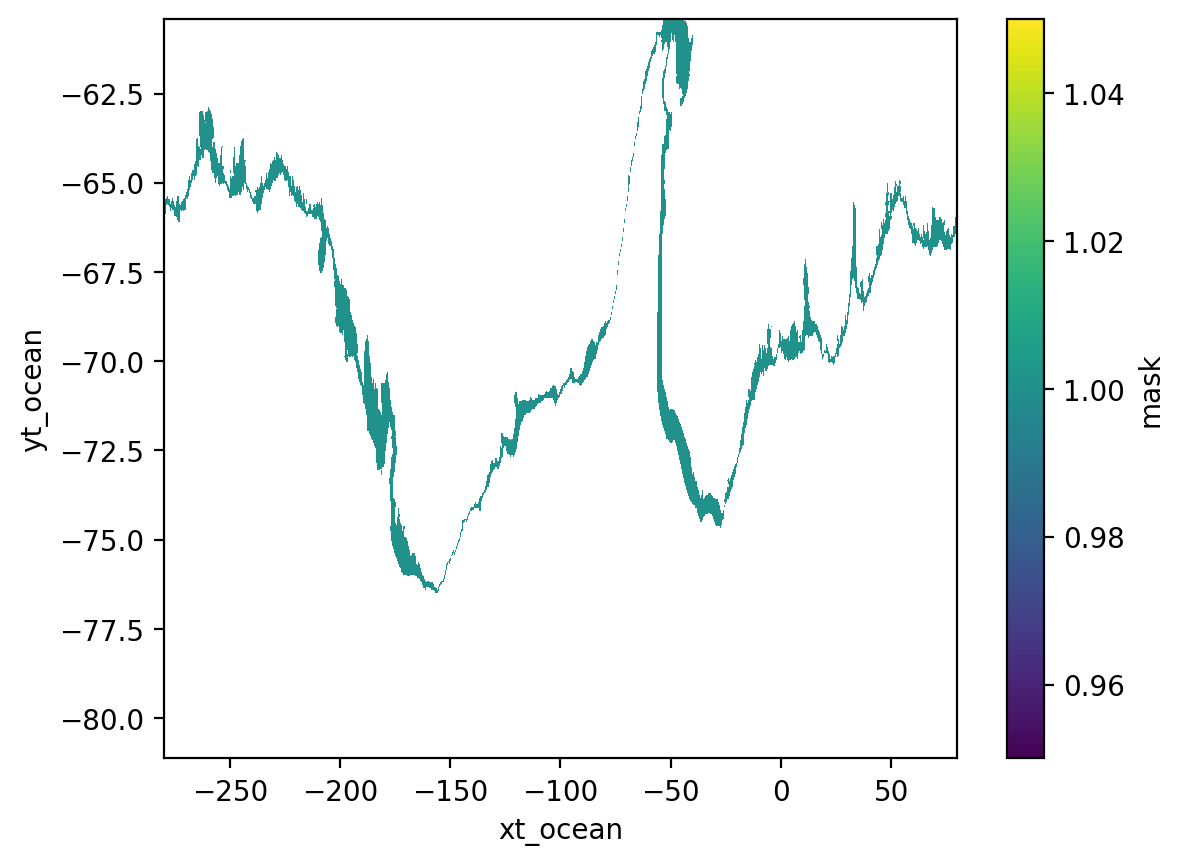

In [15]:
mask_88mto2500m=xr.open_dataset('/g/data/v45/wf4500/mask_88mto2500m.nc')
mask_88mto2500m  = mask_88mto2500m.rename(__xarray_dataarray_variable__='mask')
mask_88mto2500m.mask.plot()
isobath = mask_88mto2500m.mask

In [18]:
#Applying the mask to UVel
UVELmeanzm2 =  UVELmeanz + isobath - isobath #Applying the mask
# Calculating the speed
V = np.sqrt(np.square(UVELmeanzm2) + np.square(VVELmeanz)).compute()
#V = V.rename(salt='speed')

#UVELmeanzm2 =UVELmeanzm2.compute()
# UVELmeanz = UVELmeanz.compute()
# UVELmeanzm2

Text(0.5, 1.0, 'Speed field under  to 2500m] isobath')

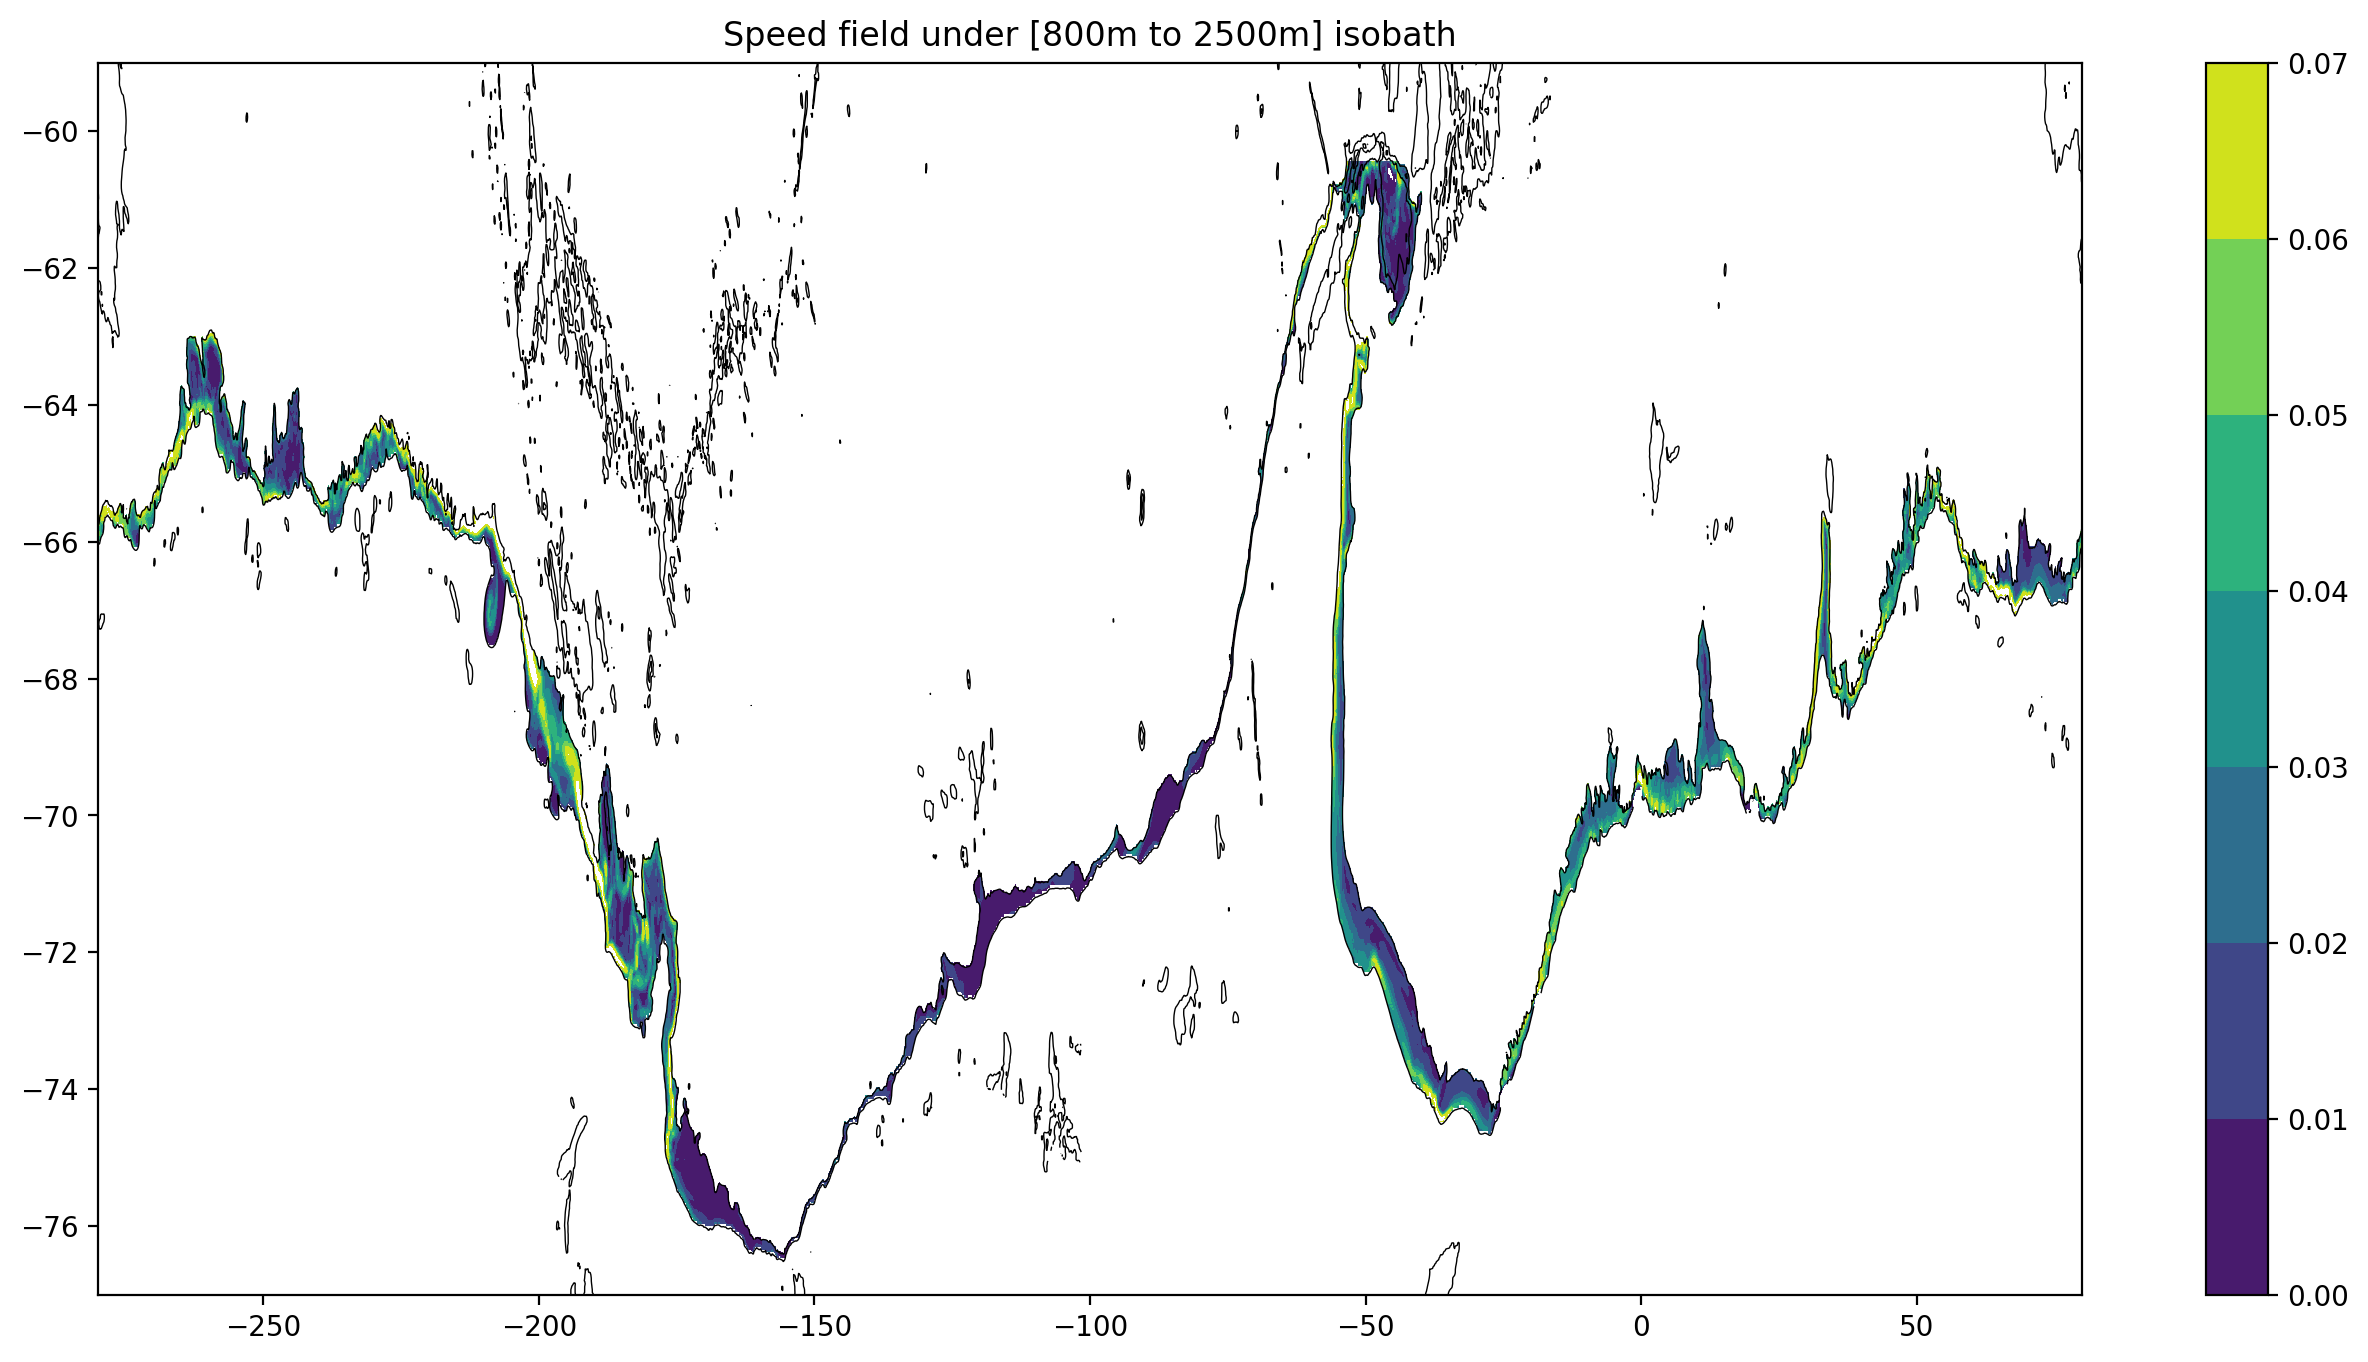

In [70]:
# Checking the mask over the Uvels ... it seems correct
fig = plt.figure(figsize = (16, 8))
plt.contourf(V.xt_ocean,V.yt_ocean,V,np.arange(0,0.07,0.01))
plt.colorbar()
sc = plt.contour(h.xt_ocean,h.yt_ocean,h, levels=[800,2500],colors='k',linewidths=0.5)
plt.ylim(-77,-59)
plt.title('Speed field under [800m to 2500m] isobath')

In [ ]:
Distribution of velociities

## Plotting stereographic map of V
Instead, let's plot the same data with cartopy. This example uses the `Robinson` global projection -- but note that key argument in the plot function: `transform=ccrs.PlateCarree()` -- which is needed every time you plot something with cartopy. (Confusingly, you could also use a `PlateCarree` projection, not to be confused with the transformation ...)

In [71]:
# projection = ccrs.SouthPolarStereo()

# import matplotlib.path as mpath
# import cartopy.feature as cft

# land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
#                                    edgecolor='black', facecolor='papayawhip', linewidth=0.5)

# plt.figure(figsize=(6, 5))
# ax = plt.axes(projection=projection)

# ax.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree())
# ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
# ax.coastlines(resolution='50m')
# ax.gridlines(draw_labels=True,ylocs=[-65,-60],xlocs=[125,115])

# theta = np.linspace(0, 2*np.pi, 100)
# center, radius = [0.5, 0.5], 0.5
# verts = np.vstack([np.sin(theta), np.cos(theta)]).T
# circle = mpath.Path(verts * radius + center)
# ax.set_boundary(circle, transform=ax.transAxes)

# V.plot(x='xt_ocean', y='yt_ocean',
#          transform=ccrs.PlateCarree(),
#          vmin=0, vmax=.02, extend='both',
#          cmap=cm.cm.speed,
#          cbar_kwargs = {'label': '|V|',
#                         'fraction': 0.03,
#                         'aspect': 15,
#                         'shrink': 0.7});

By the plot above, I think we might need ti use a even deeper isobath. See for example, in the eastern WEDDELL SEA THE CONTOUR IS JUST TOO THIN.

In [38]:
UVELmeanz2a = UVELmeanzm2.sel({'xt_ocean': slice(-246, -237)}).mean('xt_ocean')#.compute()
UVELmeanz2a = UVELmeanz2a#.compute()
humean=hu.sel({'xu_ocean': slice(-246, -237)}).mean('xu_ocean').compute()

Lets take a look at some small regions of interest (Totten and Amery)

Text(0.5, 1.0, 'Totten Ice Shelf')

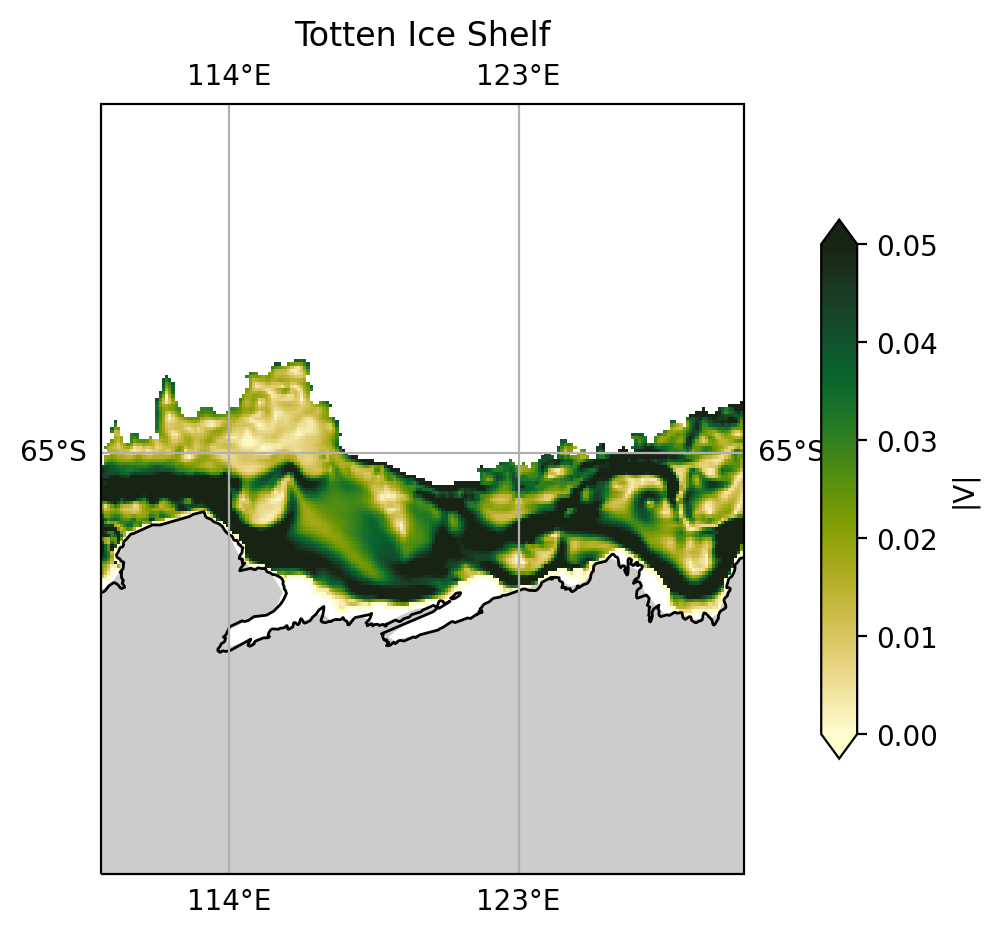

In [41]:
projection = ccrs.Mercator(central_longitude=120, min_latitude=-80.0, max_latitude=-55)

plt.figure(figsize=(10, 5))
ax = plt.axes(projection=projection)

ax.set_extent([110, 130, -70, -60], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='10m')
ax.gridlines(draw_labels=True,ylocs=[-65],xlocs=[123,114])
V.speed.plot(x='xt_ocean', y='yt_ocean',
         transform=ccrs.PlateCarree(),
         vmin=0, vmax=.05, extend='both',
         cmap=cm.cm.speed,
         cbar_kwargs = {'label': '|V|',
                        'fraction': 0.03,
                        'aspect': 15,
                        'shrink': 0.7});
plt.title('Totten Ice Shelf')

In [19]:
# #maximum negative speed seem to be ~67S. but South of 64S, all zonal speed seems negative (ASC)

# fig, ax1 = plt.subplots()
# #ax2 = ax1.twinx()
# #Batrhymetry
# ax1.plot(UVELmeanz2a['yt_ocean'], UVELmeanz2a, 'b-')
# ax1.plot(UVELmeanz2a['yt_ocean'].sel(yt_ocean=-65.46, method='nearest'), UVELmeanz2a.sel(yt_ocean=-65.46, method='nearest'), 'k*')
# ax1.set_xlabel('Latitude')
# ax1.grid()
# #Uvel
# #ax2.plot(UVELmeanz2['yt_ocean'],UVELmeanz2, 'g-')
# #ax2.grid()


# ax1.set_ylabel('Bathymetry [m]', color='b')
# plt.title('Totten Ice Shelf')

Text(0.5, 1.0, 'Amery Ice Shelf')

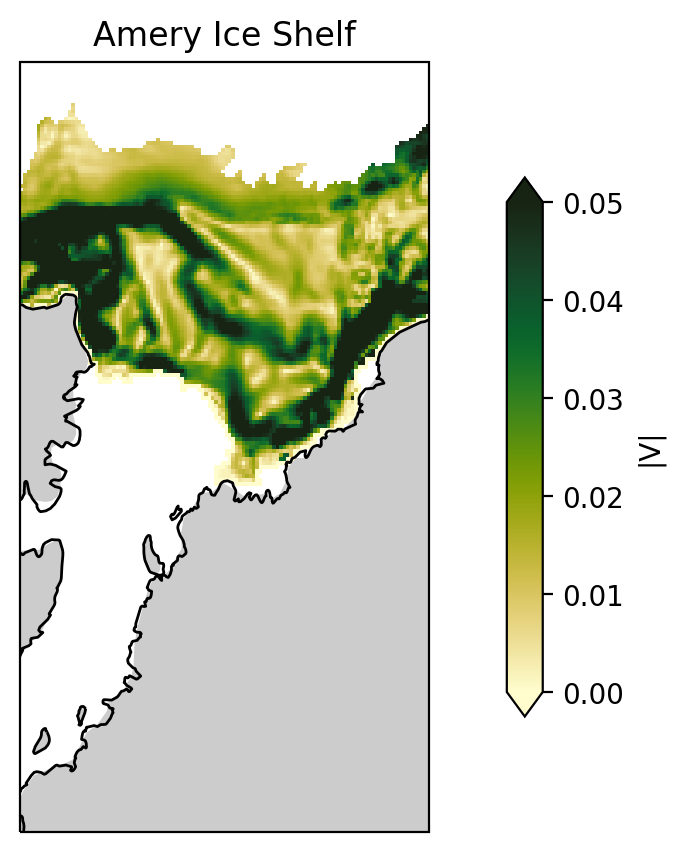

In [43]:
projection = ccrs.Mercator(central_longitude=72, min_latitude=-80.0, max_latitude=-55)

plt.figure(figsize=(10, 5))
ax = plt.axes(projection=projection)

ax.set_extent([80, 68, -73, -65], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='10m')
ax.gridlines(draw_labels=True,ylocs=[-65],xlocs=[123,114])
V.speed.plot(x='xt_ocean', y='yt_ocean',
         transform=ccrs.PlateCarree(),
         vmin=0, vmax=.05, extend='both',
         cmap=cm.cm.speed,
         cbar_kwargs = {'label': '|V|',
                        'fraction': 0.03,
                        'aspect': 15,
                        'shrink': 0.7});
plt.title('Amery Ice Shelf')

In [44]:
UVELmeanza = UVELmeanz.sel({'xt_ocean': slice(68, 80)}).mean('xt_ocean')#.compute()
UVELmeanza = UVELmeanza#.compute()
humeana=hu.sel({'xu_ocean': slice(68, 80)}).mean('xu_ocean').compute()

In [23]:
# #maximum negative speed seem to be ~67S. but South of 64S, all zonal speed seems negative (ASC)

# fig, ax1 = plt.subplots()
# #ax2 = ax1.twinx()
# #Batrhymetry
# ax1.plot(UVELmeanza['yt_ocean'], UVELmeanza, 'b-')
# ax1.plot(UVELmeanza['yt_ocean'].sel(yt_ocean=-66.77, method='nearest'), UVELmeanza.sel(yt_ocean=-66.77, method='nearest'), 'k*')
# ax1.set_xlabel('Latitude')
# ax1.grid()



# ax1.set_ylabel('Bathymetry [m]', color='b')
# plt.title('Amery Ice Shelf')

### Part 2 - Getting the locationg of the Antarctic Slope Front through the slope values

Now we need to define the ASC. I will use the maximum slope value for a specific isopycnal to define that. <a href="https://journals.ametsoc.org/view/journals/phoc/52/3/JPO-D-21-0143.1.xml">Huneke et al (2022)</a> shows that for ACCESS-OM2-01, the density surface with ρ=27.8 kg m$^{-3}$ seem to have a large depth variation according to the shelf regime of the ASC. You can see that in the figure below. So we will use the maximum absolute value of the slope to locate the ASC.

<div>
<img src="Screen Shot 2023-05-02 at 3.35.01 PM.png" width="600"/>
</div>

The next steps will then be....

**2.1 - Step 1 :** Find the depth of the the ρ=27.8 kg m$^{-3}$ surface accross the domain

**2.2. - Step 2 :** For each point of the domain, find the slope, along the latitudes, of the ρ=27.8 kg m$^{-3}$ isopycnal surface. This is defined here as $|Δz/ΔS|$. For a point located in $(x_{n},y_{n})$ in a Lon(x),Lat(y) field, that would be defined by its adjacent points:

$ |(\frac{Δz}{Δs})_{n}| = \frac{Z_{n+1}\ -\ Z_{n-1}  }{Lat_{n+1}\ -\ Lat_{n-1}}  \ \ [\frac{m}{^{o}}]$

Notice that $Δz/ΔS < 0$ for the case of isopycnals getting shallower northwards (Surface-intensified ASC) becasue we define $Lat_{n+1}$ as always south from $Lat_{n-1}$.  $Δz/ΔS > 0$ for the case of isopycnals getting deeper northwards (Reversed ASC). In turn, the bottom intensified ASC case, we can either get positive or negative values, depending if we are getting isopycnal above or below the shelf overflow. That is why we need to get the maximum _absolute_ value of the slope.
        
**2.3 - Step 3 :** Define the limit of the maximum absolute slope based on the maximum slope $|Δz/ΔS|_{n} ^{max}$. We do not want only the single point of the maximum slope, but a range of locations where this slope represents the Antarctic Slope Front (ASF). Therefore we will define the ASF as the locations where the slope of the ρ=27.8 kg m$^{-3}$ isopycnal is at least 20% of the maximum absolute isopycnal slope $|Δz/ΔS|_{n} ^{max}$. So for example, if $|Δz/ΔS| = 100\ \frac{m}{^{o}}$ , then all grid points where $Δz/ΔS >20\ \frac{m}{^{o}}$ or $Δz/ΔS <-20\ \frac{m}{^{o}}$ will be included in the domain. This approach will allow ASF to strech and squeeze latitudinally as necessary, instead of having a fixed latitudinal band.

**2.4 - Step 4 :** Mask all the values where $Δz/ΔS <(0.2*|Δz/ΔS|_{n} ^{max} )$ . The remaining unmasked values will be the domain of the ASF and ASC, and should look like the figure below. Notice that a validation to see if this method works correctly should be done (e.g., plot mean speed to check it)


**Step 1 :** Find the depth of the the ρ=27.8 kg m$^{-3}$ surface accross the domain

In [69]:
#Getting the density
rhoref=1027.8 #reference density we want to map out
pot_rho_0 = cc.querying.getvar(experiment, 'pot_rho_0' , session, frequency='1 monthly', n=-40)
pot_rho_0 = pot_rho_0.isel({'yt_ocean': slice(0, 482)}).groupby('time.year').mean(dim='time').mean(dim='year')

#Obtaining the absolute value of the difference between the rho_0 and the reference density 27.8
pot_rho_a = np.array(abs(pot_rho_0-rhoref))

In [78]:
%%time
#Masking anything north of the 2500m isobath
pot_rho_a2  = pot_rho_a[0]  + isobath - isobath 

for n in range(1,75):
    test  = pot_rho_a[n]  + isobath - isobath 
    pot_rho_a2 = xr.concat((pot_rho_a2,test),dim='st_ocean')


In [221]:
# #Reducing all-nan y dumension to reduce errors
pot_rho_a2 = pot_rho_a2.isel(st_ocean=slice(0,59))
pot_rho_a2['st_ocean']=np.array(pot_rho_0.st_ocean.isel(st_ocean=slice(0,59)))
pot_rho_a3=pot_rho_a2.fillna(9999)

In [239]:
# Finding the depth where rho_0 is closest to rhoref (by the minumum of the absolute difference)
zindex = np.nanargmin(pot_rho_a3.dens, axis=0)
#zindex = pot_rho_a2.dens.argmin(axis=0)
#Z278 = np.nanmin(pot_rho_a2.dens, axis=0)
Z=np.array(pot_rho_0['st_ocean'])
Z278=Z[zindex] #Approximate depth of the surface dens 27.8

#multiplying the depths we found by our mask
Z278_masked =  Z278 + isobath - isobath 
Z278_masked = Z278_masked.rename(salt = 'depth')

Text(0.5, 1.0, 'Depth of $\\rho=1027.8\\ Kg\\ m^{-3}$')

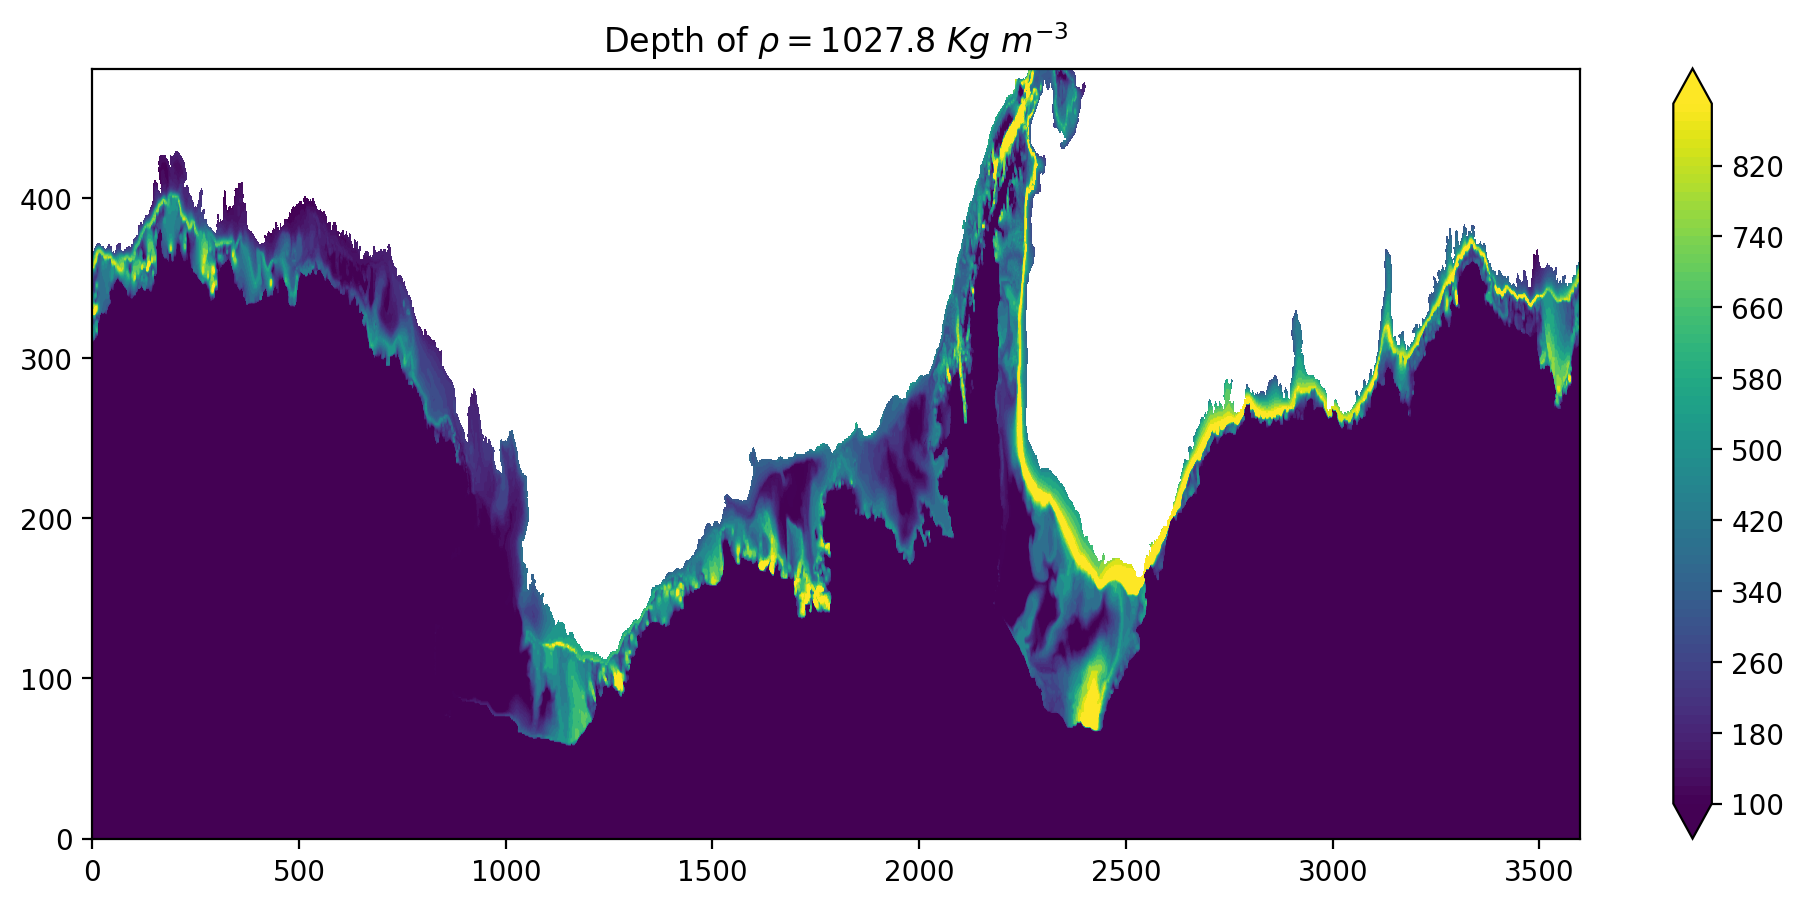

In [381]:
#THis is the depth of the model closet to the 1027.8 kg m-3 isopycnal
figure = plt.figure(num=1, figsize = (12,5))
plt.contourf(Z278_masked.depth,np.arange(100,900,10),extend='both')
plt.colorbar()
plt.title(r"Depth of $\rho=1027.8\ Kg\ m^{-3}$")

**FOR SOME REASON THE DELTAZS ANDINDEXES ARE ALL WRONG, AND I CANT FIGURE OUT WHY NOW. I WILL HAVE TO PAUSE THIS FOR NOW, BUT WILL TRY TO SOVE IT AGAIN NEXT WEEK**

What about using the speeds between the 800 and 1000 m isobaths - Figure out which isobaths best isolate the ASC -  Talk to wilma about it

Taimoor
Ellie 
Fabio
Wilma
Paul
Adele
Wilton


Check the heat transport in different depth slices, instead of fully integrated. 

In [382]:
#Distance along latitudes
from geopy.distance import geodesic as GD
lat_along_contour2=pot_rho_0['yt_ocean']
lon_along_contour2=np.zeros(np.shape(pot_rho_0['yt_ocean']))


meridional_distances = GD((lat_along_contour2[0],lon_along_contour2[0]) ,(lat_along_contour2[1],lon_along_contour2[1])).km
meridional_distances= np.tile(meridional_distances,(481)).T 
deltaS3 = np.tile(meridional_distances,(3600,1)).T 
np.shape(deltaS3 )

(481, 3600)

2023-05-09 15:45:52,513 - distributed.nanny - WARNING - Restarting worker
2023-05-09 15:45:52,802 - distributed.nanny - WARNING - Restarting worker
2023-05-09 15:45:52,832 - distributed.nanny - WARNING - Restarting worker
2023-05-09 15:45:53,063 - distributed.nanny - WARNING - Restarting worker
2023-05-09 15:45:53,612 - distributed.nanny - WARNING - Restarting worker
2023-05-09 15:45:53,819 - distributed.nanny - WARNING - Restarting worker
2023-05-09 15:45:53,825 - distributed.nanny - WARNING - Restarting worker
2023-05-09 15:45:54,335 - distributed.nanny - WARNING - Restarting worker
2023-05-09 15:45:54,340 - distributed.nanny - WARNING - Restarting worker
2023-05-09 15:45:54,499 - distributed.nanny - WARNING - Restarting worker


In [332]:
#calculating deltaZ/DeltaS
deltaS=np.diff(pot_rho_0['yt_ocean'].isel(yt_ocean=slice(0,481)),n=0)
deltaS2 = np.tile(deltaS,(3600,1)).T 
#deltaZ=np.diff(Z278_masked,n=2,axis=0)
deltaZ=np.diff(Z278_masked.depth,axis=0)
#deltaZ = np.ma.masked_where(deltaZ>=1000,deltaZ,np.NaN)
#deltaZ = np.ma.masked_where(deltaZ<=-1000,deltaZ,np.NaN)
#deltaZ = np.ma.masked_where(deltaZ==0,deltaZ,np.NaN)
dzds=deltaZ/deltaS3

In [368]:
#MAsking dzds
dzds_ = dzds + pot_rho_0.isel(st_ocean=0,yt_ocean=slice(0,481)) - pot_rho_0.isel(st_ocean=0,yt_ocean=slice(0,481))

Text(0.5, 1.0, '$ \\frac{\\delta Z}{\\delta S^{j}} [\\frac{m}{km}]$ for $\\rho _{0} = 1027.8\\ Kg\\ m^{-3}$  - Climatology [RYF]')

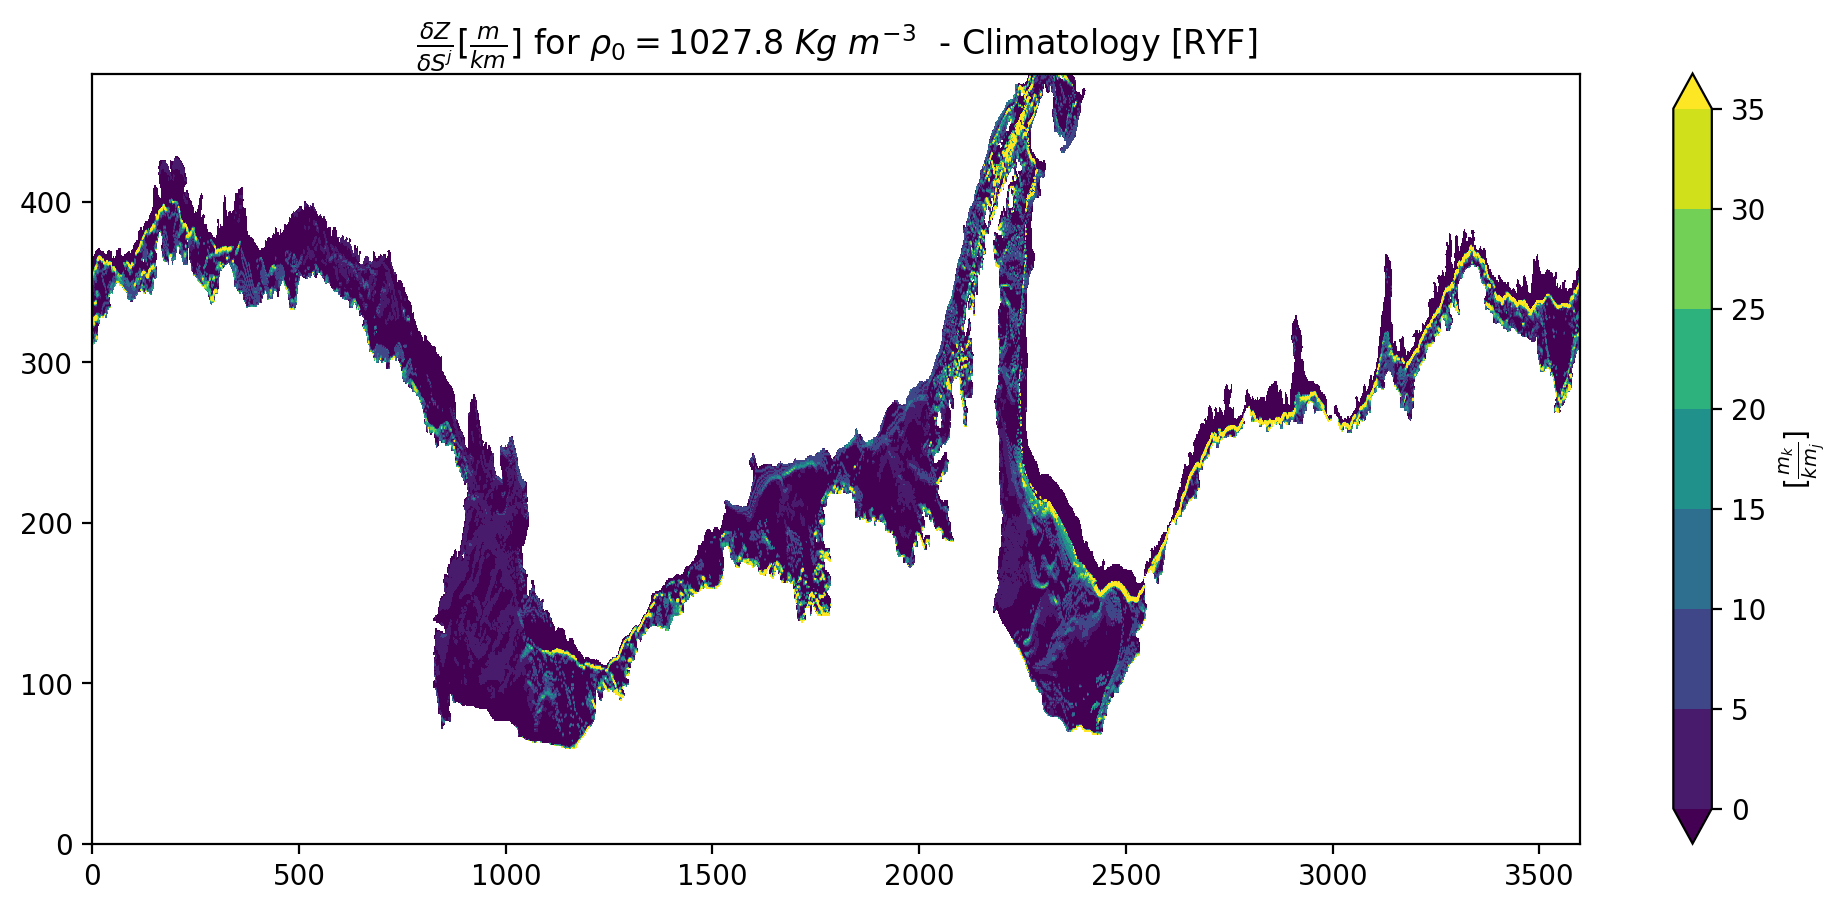

In [378]:
figure = plt.figure(num=1, figsize = (12,5))
plt.contourf(dzds_,np.arange(0,40,5),extend='both')
plt.colorbar(label=r"$[\frac{m_{k}}{km_{j}}]$")
plt.title(r"$ \frac{\delta Z}{\delta S^{j}} [\frac{m}{km}]$ for $\rho _{0} = 1027.8\ Kg\ m^{-3}$  - Climatology [RYF]")

In [113]:
deltaZmaxind = np.nanargmax(deltaZ,axis=0) #index along latitudes
deltaZmax = np.nanmax(deltaZ,axis=0)
ytocean=pot_rho_0['yt_ocean']
# deltaZmax = deltaZ[deltaZmaxind]

(1038674,)

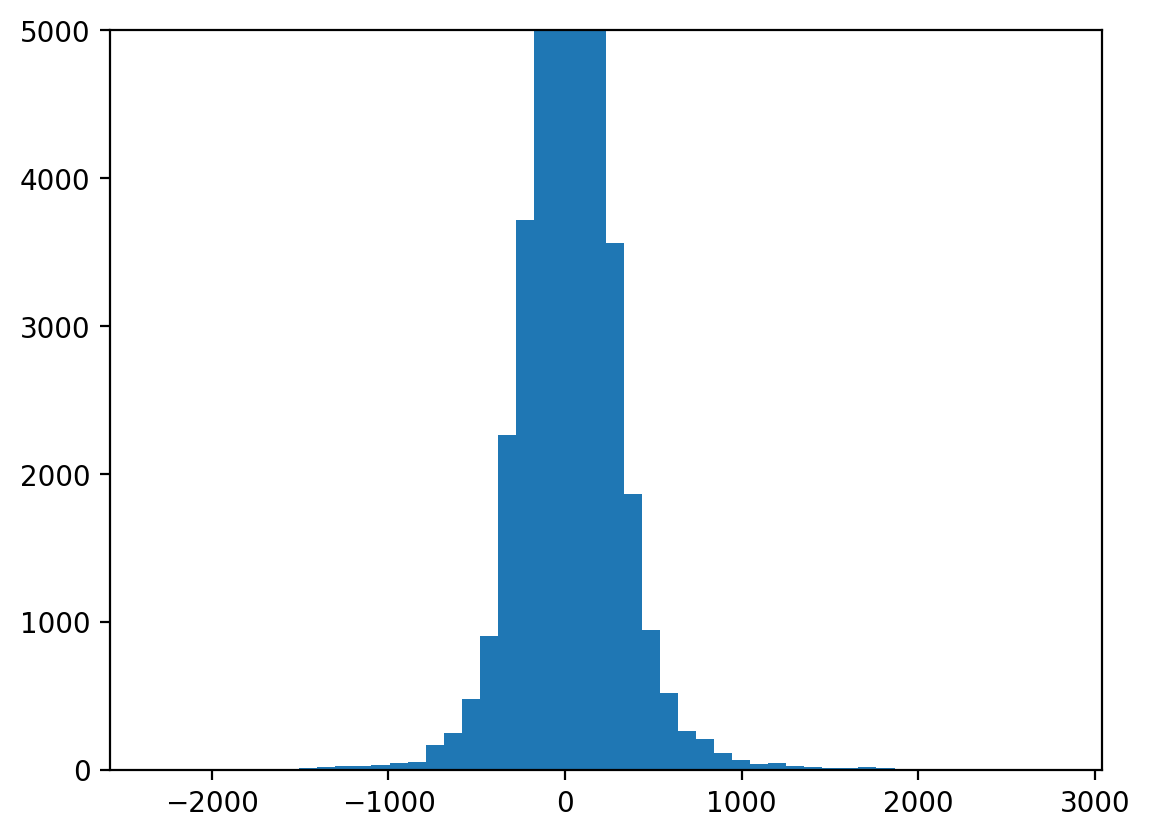

In [116]:
# CHecking an histogram - why do we have values above 1000, when maximum dzt is ~250 for the grid?
nonandz = deltaZ[~np.isnan(deltaZ)]
nonandz = nonandz[nonandz!=0]

pylab.figure()
pylab.hist(nonandz,bins=50)
plt.ylim(0,5000)
#histogram = np.histogram(isnumeric(Z278_masked),bins=20)
#plt.plot(histogram[0],histogram[1])

In [121]:
range(3600)

range(0, 3600)

In [131]:
xt_ocean=pot_rho_0['xt_ocean']

427

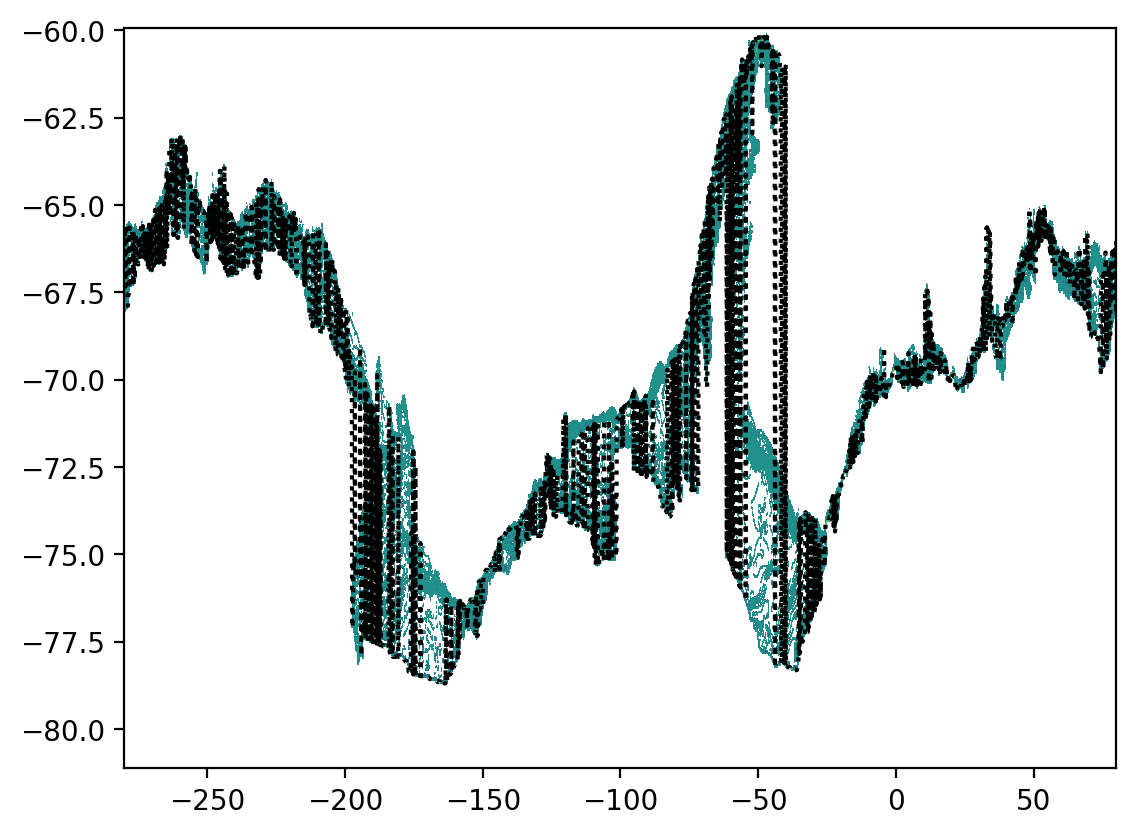

In [138]:
plt.contourf(xt_ocean,yt_ocean[:492],deltaZ)
plt.plot(xt_ocean,yt_ocean[np.array(deltaZmaxind)],':k')
#plt.colorbar()

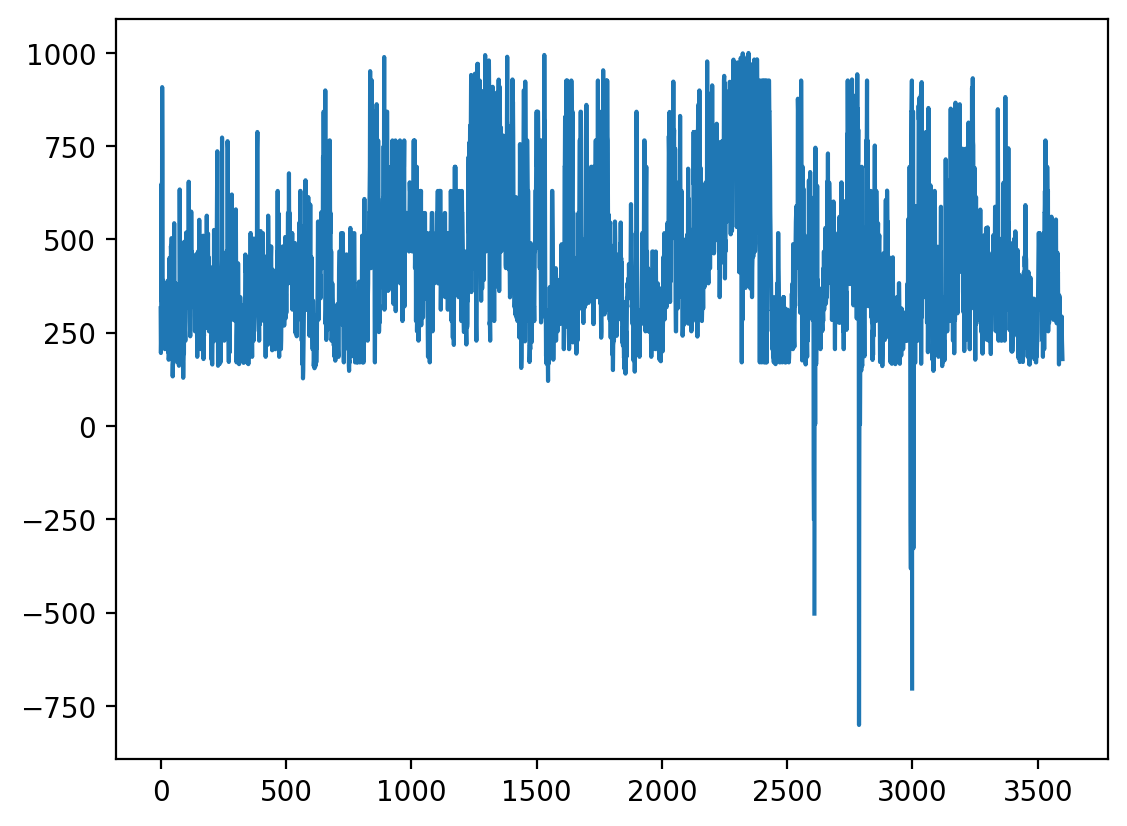

In [64]:
plt.plot(deltaZmax)
